# Spark DataFrame - Data Cleaning
There are three options when dealing with missing data: 
1. Changing the data to null
2. Drop the data point (or entire row)
3. Fill it in with a different value

These points are dependent on your requirements. 

Objective: Let's explore our options when it comes to cleaning a basic dataset.

In [49]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()

In [50]:
# Importing data which has a header. Schema is automatically configured.
df = spark.read.csv('modify1.csv', header=True, inferSchema=True)
heart_data_situation = spark.read.csv('heart-data-situation.csv', header=True, inferSchema=True)

merged_df = df.join(heart_data_situation, on="id", how="inner")  

# Let's see the data. You'll notice nulls.
merged_df.show()

+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|index|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|    0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|    1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|    2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|    3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|    4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|    5|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|    6|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|    7|22584|     2|   178|  95.0|  130|   90|          3|   3|   

+-----------+----------+
|    Feature|Importance|
+-----------+----------+
|      ap_hi|      0.59|
|      ap_lo|      0.22|
|        age|      0.09|
|cholesterol|      0.08|
|     weight|      0.01|
|       gluc|      0.01|
|     active|       0.0|
|     height|       0.0|
|      smoke|       0.0|
|       alco|       0.0|
|         id|       0.0|
|      index|       0.0|
+-----------+----------+



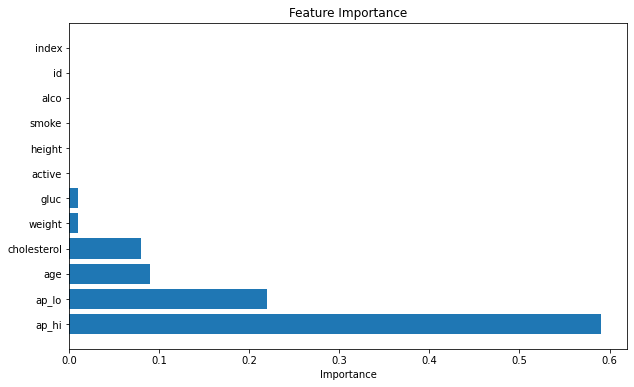

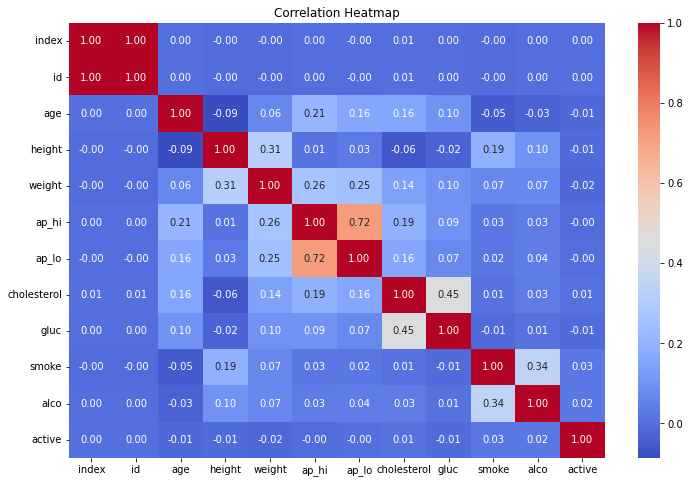

In [51]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler


feature_cols = ['index', 'id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(merged_df)

rf = RandomForestClassifier(featuresCol="features", labelCol="cardio")
model = rf.fit(assembled_data)

importances = model.featureImportances.toArray()

importances_list = [(feature, float(importance)) for feature, importance in zip(feature_cols, importances)]
importance_df = spark.createDataFrame(importances_list, ["Feature", "Importance"])

importance_df = importance_df.orderBy("Importance", ascending=False)

from pyspark.sql.functions import round

importance_df = importance_df.withColumn("Importance", round(importance_df["Importance"], 2))
importance_df.show()

import matplotlib.pyplot as plt


feature_names = importance_df.select("Feature").rdd.flatMap(lambda x: x).collect()
importance_values = importance_df.select("Importance").rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importance_values, align="center")
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Importance")
plt.title("Feature Importance")

plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = merged_df.select(feature_cols).toPandas().corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



In [52]:
merged_df.describe().toPandas()

,summary,id,index,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,count,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056,68056
1,mean,49961.38948806865,34991.75198366051,19467.796329493358,1.3482132361584578,164.41048548254378,73.72453273774539,126.59862466204302,81.28977606676854,1.3629657928764547,1.2239773128012226,0.08756024450452568,0.05310332667215235,0.8037057717174092,0.4936228987892324
2,stddev,28838.84055511243,20198.679156291822,2466.8985187743706,0.4764075075852865,7.825610733050222,13.423933068620316,16.517518537922864,9.398565292233743,0.6778290292171032,0.5698690836303668,0.2826563674162662,0.22424116979742773,0.39719657902829786,0.4999630041132576
3,min,0,0,10798,1,130,30.0,90,40,1,1,0,0,0,0
4,max,99999,69999,23713,2,207,120.0,220,140,3,3,1,1,1,1


In [53]:
from pyspark.sql.functions import col, round

# Calculate BMI
merged_df = merged_df.withColumn("bmi", col("weight") / ((col("height") / 100) ** 2))

# Round BMI to 2 decimal places
merged_df = merged_df.withColumn("bmi", round(col("bmi"), 2))

# Show descriptive statistics for BMI
merged_df.describe("bmi").show()


+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             68056|
|   mean|27.313671829080924|
| stddev| 4.934954139584941|
|    min|             10.73|
|    max|             58.02|
+-------+------------------+



In [54]:
from pyspark.sql.functions import when, col

# Define the conditions for outliers
condition = (col("bmi") >= 16) & (col("bmi") <= 35)

# Filter out the outliers
merged_df = merged_df.filter(condition)
merged_df.describe("bmi").show()



+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             62526|
|   mean|26.353332693598585|
| stddev| 3.726173091386141|
|    min|              16.0|
|    max|              35.0|
+-------+------------------+



In [55]:
from pyspark.sql.functions import col, round

# Convert 'age' from days to years and round it to 1 decimal place
merged_df = merged_df.withColumn("age", round(col("age") / 365.0, 1))
merged_df.show()


+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
| id|index| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|  0|    0|50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|  1|    1|55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|  2|    2|51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|  3|    3|48.3|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|  4|    4|47.9|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|  8|    5|60.0|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
| 12|    7|61.9|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|29.98|
| 13|    8|48.4|    

In [56]:
# Dropping multiple columns in PySpark
merged_df = merged_df.drop('id', 'index', 'height', 'weight')
merged_df.show()

merged_df.describe().toPandas()

+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
| age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
|50.4|     2|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|55.4|     1|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|51.7|     1|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|48.3|     2|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|47.9|     1|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|60.0|     1|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
|61.9|     2|  130|   90|          3|   3|    0|   0|     1|     1|29.98|
|48.4|     1|  110|   70|          1|   1|    0|   0|     1|     0|28.44|
|54.3|     1|  110|   60|          1|   1|    0|   0|     0|     0|25.28|
|61.7|     1|  120|   80|          1|   1|    0|   0|     1|     0|28.01|
|51.5|     2|  120|   80|          1| 

,summary,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,count,62526,62526,62526,62526,62526,62526,62526,62526,62526,62526,62526
1,mean,53.22312478009127,1.3642004925950804,125.8630489716278,80.94085660365288,1.341234046636599,1.2123116783418098,0.09058631609250552,0.05317787800275085,0.8051370629817995,0.47786520807344146,26.353332693598585
2,stddev,6.768652128853364,0.48120909929374633,16.121201424191657,9.236778949903327,0.6601398126658283,0.5581508636252147,0.2870222168913714,0.22438983170283314,0.39609832371912385,0.4995138051655428,3.726173091386141
3,min,29.6,1,90,40,1,1,0,0,0,0,16.0
4,max,65.0,2,220,140,3,3,1,1,1,1,35.0


In [57]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql import DataFrame
def balance_features(df, binary_features, multiclass_features, binary_class_features):
    balanced_df = df

    # 'active', 'smoke', 'alco'
    for feature in binary_features:
        high_count = df.filter(col(feature) == 0).count()
        low_values = df.filter(col(feature) == 1)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 0).union(low_values_upsampled)

    # 'gluc', 'cholesterol'
    for feature in multiclass_features:
        feature_categories = [row[feature] for row in df.select(feature).distinct().collect()]
        for category in feature_categories:
            high_count = df.filter(col(feature) != category).count()
            low_values = df.filter(col(feature) == category)
            low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
            balanced_df = df.filter(col(feature) != category).union(low_values_upsampled)

    # 'gender'
    for feature in binary_class_features:
        high_count = df.filter(col(feature) == 1).count()
        low_values = df.filter(col(feature) == 2)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 1).union(low_values_upsampled)

    return balanced_df

# Create a Spark DataFrame from your original data source
# e.g., merged_df = spark.read.csv("path_to_your_data.csv", header=True, inferSchema=True)

binary_features = ['active', 'smoke', 'alco']
multiclass_features = ['gluc', 'cholesterol']
binary_class_features = ['gender']

balanced_df = balance_features(merged_df, binary_features, multiclass_features, binary_class_features)




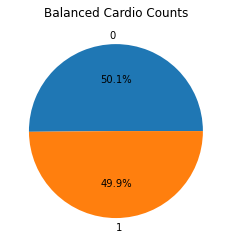

In [40]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Balance 'cardio'
cardio_0_count = balanced_df.filter(col('cardio') == 0).count()
cardio_1_values = balanced_df.filter(col('cardio') == 1)
cardio_1_upsampled = cardio_1_values.sample(True, cardio_0_count / cardio_1_values.count(), seed=42)
balanced_df = balanced_df.filter(col('cardio') == 0).union(cardio_1_upsampled)

# Check counts for visualization
cardio_counts = balanced_df.groupby('cardio').agg(count('cardio').alias('count')).collect()

# Using matplotlib to plot
labels = [row['cardio'] for row in cardio_counts]
sizes = [row['count'] for row in cardio_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Balanced Cardio Counts')
plt.show()


In [58]:
balanced_df.describe().toPandas()

,summary,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,count,79379,79379,79379,79379,79379,79379,79379,79379,79379,79379,79379
1,mean,53.20907796772443,1.4991874425225815,126.25681855402563,81.15291197923884,1.338842766978672,1.2108114236762872,0.11742400382972827,0.06402197054636617,0.8050114010002646,0.48194106753675403,26.29360649542094
2,stddev,6.813073051380141,0.5000024892230953,16.231605643192587,9.236389533374771,0.6580127290185865,0.5556791154519428,0.3219268748495901,0.24479361254455992,0.396194425421778,0.4996769159537433,3.684560224453728
3,min,29.6,1,90,40,1,1,0,0,0,0,16.0
4,max,64.9,2,220,140,3,3,1,1,1,1,35.0


Great work! At this stage, we're pretty much done with understanding DataFrames. You can now move on to applying an algorithm. We recommend going through linear regression, then logistic regression and finishing off with tree methods. It's best to start with the documentation example before moving to the advanced example. 

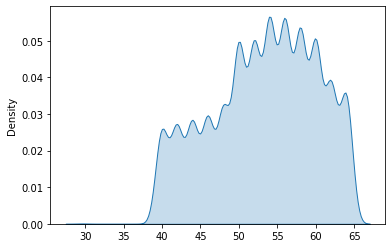

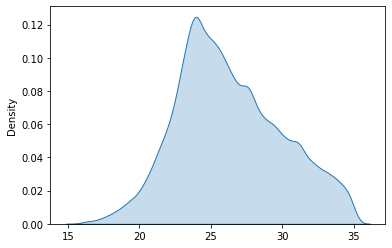

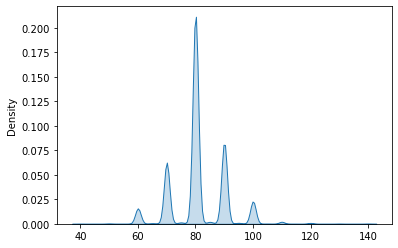

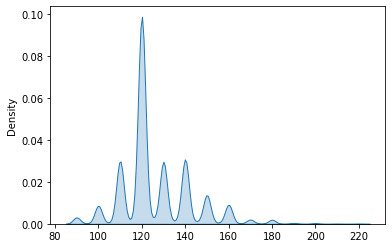

In [59]:

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Assuming 'balanced_df' is your DataFrame

def plot_kde(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    sns.kdeplot(sampled_data, shade=True)
    plt.show()

# Plot KDE plots
plot_kde(balanced_df, 'age')
plot_kde(balanced_df, 'bmi')
plot_kde(balanced_df, 'ap_lo')
plot_kde(balanced_df, 'ap_hi')

# Calculate skewness
def calculate_skew(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    return skew(sampled_data)

skew_age = calculate_skew(balanced_df, 'age')
skew_bmi = calculate_skew(balanced_df, 'bmi')
skew_ap_lo = calculate_skew(balanced_df, 'ap_lo')
skew_ap_hi = calculate_skew(balanced_df, 'ap_hi')

In [60]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi)

Age Skewness: -0.2820574129138585
BMI Skewness: 0.2807891966113754
ap_lo Skewness: 0.3516900785125172
ap_hi Skewness: 0.986712851046705


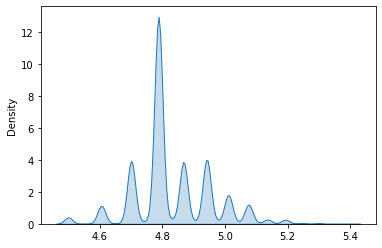

ap_hi Skewness (after transformation): 0.48689805884263954


In [61]:
balanced_df = balanced_df.withColumn('ap_hi', F.log('ap_hi'))
plot_kde(balanced_df, 'ap_hi')
skew_ap_hi_after = calculate_skew(balanced_df, 'ap_hi')
print("ap_hi Skewness (after transformation):", skew_ap_hi_after)

In [62]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi_after)

Age Skewness: -0.2820574129138585
BMI Skewness: 0.2807891966113754
ap_lo Skewness: 0.3516900785125172
ap_hi Skewness: 0.48689805884263954


Accuracy: 0.7300692879205276
Weighted Precision: 0.7395052230910923
Weighted Recall: 0.7300692879205276
F1 Score: 0.7256605721162199
The actual depth of the tree is: 52


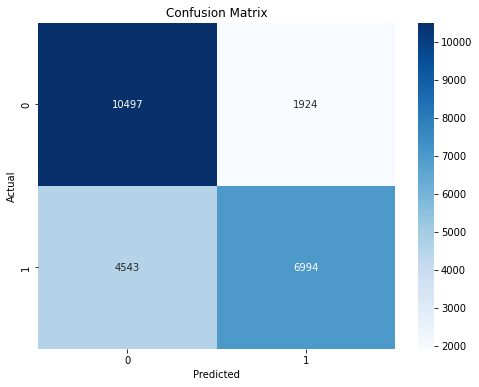

True Negatives (TN): 10497
False Positives (FP): 1924
False Negatives (FN): 4543
True Positives (TP): 6994
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8cf8bf617224, depth=5, numNodes=35, numClasses=2, numFeatures=10
  If (ap_hi <= 4.8597823571875995)
   If (age <= 55.349999999999994)
    If (cholesterol <= 2.5)
     Predict: 0.0
    Else (cholesterol > 2.5)
     If (gluc <= 2.5)
      If (bmi <= 22.689999999999998)
       Predict: 0.0
      Else (bmi > 22.689999999999998)
       Predict: 1.0
     Else (gluc > 2.5)
      Predict: 0.0
   Else (age > 55.349999999999994)
    If (cholesterol <= 2.5)
     If (age <= 60.349999999999994)
      Predict: 0.0
     Else (age > 60.349999999999994)
      If (active <= 0.5)
       Predict: 1.0
      Else (active > 0.5)
       Predict: 0.0
    Else (cholesterol > 2.5)
     Predict: 1.0
  Else (ap_hi > 4.8597823571875995)
   If (ap_hi <= 4.930863809143949)
    If (cholesterol <= 2.5)
     If (age <= 61.650000000000006)
      If (ap_lo <

In [63]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio")
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

def replace_feature_indices_with_names(tree_string, feature_columns):
    for index, feature_name in enumerate(feature_columns):
        tree_string = tree_string.replace(f"feature {index}", feature_name)
    return tree_string

tree_string = model.toDebugString
modified_tree_string = replace_feature_indices_with_names(tree_string, feature_columns)
print(modified_tree_string)





Accuracy: 0.7350421927542669
Weighted Precision: 0.7425040631507647
Weighted Recall: 0.7350421927542669
F1 Score: 0.73117994869361
The actual depth of the tree is: 52


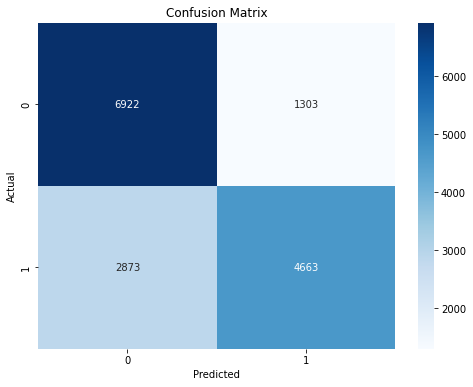

True Negatives (TN): 6922
False Positives (FP): 1303
False Negatives (FN): 2873
True Positives (TP): 4663


In [64]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio")
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Accuracy: 0.7275844868437461
Weighted Precision: 0.7300094028434279
Weighted Recall: 0.7275844868437461
F1 Score: 0.7260790164229954


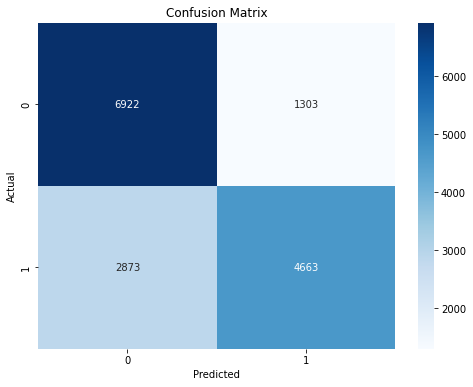

Coefficients:
bmi: 0.03524283129866981
ap_lo: 0.01264889003845174
ap_hi: 7.288463821280555
active: -0.2549113550074802
smoke: -0.11771231232651762
alco: -0.2359437435665579
gluc: -0.12876797841161233
cholesterol: 0.49740112692916494
gender: 0.028697199822890564
age: 0.050588366033650835

Intercept: -40.228739672641915


In [69]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Convert feature columns to a single vector column
feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)  

# Split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# Create and fit the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="cardio")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print("Coefficients:")
for feature, coeff in zip(feature_columns, lr_model.coefficients):
    print(f"{feature}: {coeff}")
print("\nIntercept:", lr_model.intercept)





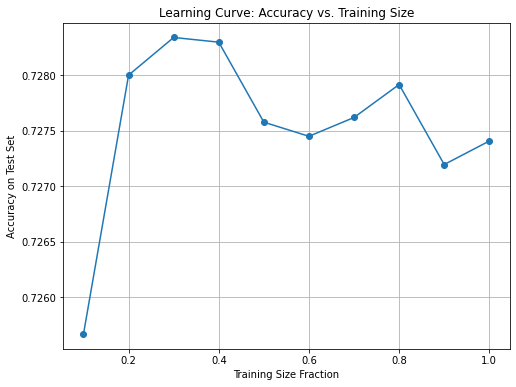

In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def train_and_evaluate(train_subset):
    lr = LogisticRegression(featuresCol="features", labelCol="cardio")
    lr_model = lr.fit(train_subset)
    predictions = lr_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="cardio", predictionCol="prediction", metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    return accuracy

sample_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = []

for fraction in sample_fractions:
    subset = train_data.sample(withReplacement=False, fraction=fraction)
    acc = train_and_evaluate(subset)
    accuracies.append(acc)

plt.figure(figsize=(8, 6))
plt.plot(sample_fractions, accuracies, '-o')
plt.title('Learning Curve: Accuracy vs. Training Size')
plt.xlabel('Training Size Fraction')
plt.ylabel('Accuracy on Test Set')
plt.grid(True)
plt.show()

